# Testing patching functions in acdc.py
## Setup

In [4]:
# Imports
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm
import sys
sys.path.append('..')

from einops import rearrange
import torch as t
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE

import matplotlib.pyplot as plt
import imageio
from circuitsvis.activations import text_neuron_activations

ModuleNotFoundError: No module named 'dictionary_learning'

In [2]:
# Global variables
ACTIVATION_DIM = 512
DICTIONARY_SIZE = 64 * ACTIVATION_DIM # This is the dict_size sam mostly works with.
EPS = 1e-8

In [3]:
# Model and SAEs
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodules = [
    layer.mlp for layer in model.gpt_neox.layers
]

dictionaries = []
for i in range(len(submodules)):
    dictionary = AutoEncoder(ACTIVATION_DIM, DICTIONARY_SIZE).to('cuda:0')
    dictionary.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/1_32768/ae.pt'))
    dictionaries.append(dictionary)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
# Toy dataset for the "Plural" task

plural_token_pos = 1
tok = lambda x: t.tensor(model.tokenizer.encode(x))
toy_dataset = [dict(
    clean_prefix=tok("The man"),
    clean_answer=tok(" is"),
    patch_prefix=tok("The men"),
    patch_answer=tok(" are"),

)]

toy_dataset[0]['clean_prefix']

tensor([ 510, 1821])

In [7]:
# Diverse dataset for Circuitvis evaluation

# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

# Buffer tied to one specific submodule!
buffer = ActivationBuffer(
    data,
    model,
    submodules[0], # we only use data from the buffer, not acttivations. Thus we can pass any submodule here
    io='out',
    in_feats=ACTIVATION_DIM,
    out_feats=ACTIVATION_DIM,
    in_batch_size=512,
    out_batch_size=2 ** 15,
    n_ctxs=1e4,
)

# returns activations on dataset examples for the submodule specified
# for each example, activations per each token positon are concatenated along dim out_batch_size
# acts = next(buffer) # [out_batch_size, activation_size]
tokenized_prompts = buffer.tokenized_batch(batch_size=512) # [batch, n_ctx]

refreshing buffer...


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


buffer refreshed...


torch.Size([32768, 512])

In [14]:
# Circuitsvis visualization

def get_feature_activations(layer):
    '''
    Function for retrieving feature activations from tokenized batch
    returns activations for all submodules, dictionaries if layer == None
    
    '''
    with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
        with generator.invoke(tokenized_prompts['input_ids'], scan=False) as invoker:
            hidden_states = submodules[layer].output.save() # hidden_states.value: [batch, n_ctx, d_mlp]
    dictionary_activation = dictionaries[layer].encode(hidden_states.value)
    return dictionary_activation

def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]
    
def topk_prompts_provider(feature_layer: int, feature_id: int, k: int = 30):
    # Sort examples in batch by max feature activation
    dictionary_activations = get_feature_activations(feature_layer)
    acts = dictionary_activations[:, :, feature_id].cpu() # acts: [batch, pos]
    flattened_acts = rearrange(acts, 'b l -> (b l)')
    topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k] 
    batch_indices = topk_indices // acts.shape[1]
    token_indices = topk_indices % acts.shape[1]

    # Visualize
    tokens = [
    tokenized_prompts['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
    ]
    tokens = list_decode(tokens)
    activations = [
        acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
    ]
    return tokens, activations

## Testing `patching_on_y`
Evaluate causal effects of features in layer 5 on the logit diff between clean and patch answers.

In [1]:
layer_patching_on_y = 5

In [17]:
from acdc import patching_on_y

effects_on_y, total_effect_on_y = patching_on_y(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    method='all-folded'
)
plural_effect_on_y = effects_on_y[submodules[layer_patching_on_y]][plural_token_pos].detach().cpu()

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect_on_y}')

total metric diff after replacing clean prefix with patch prefix: 8.8028564453125


In [18]:
# Top 10 features in layer `layer_patching_on_y` with highest impact on logit diff

topk_effects_on_y = sorted(enumerate(plural_effect_on_y), key=lambda x: x[1].abs(), reverse=True)

topk_features_on_y = []
print(f'Top 10 features in layer {layer_patching_on_y} with highest impact on logit diff')
for i, eff in topk_effects_on_y[:10]:
    topk_features_on_y.append(i)
    print(f'feat {i}:\t {eff}')

feat 22167:	 0.2865937054157257
feat 21277:	 0.12576480209827423
feat 10880:	 0.10416737198829651
feat 14747:	 0.10214502364397049
feat 13505:	 0.07417690753936768
feat 7352:	 0.053832706063985825
feat 27530:	 -0.053781237453222275
feat 22606:	 0.031817931681871414
feat 30204:	 0.0313369482755661
feat 8810:	 -0.024746902287006378


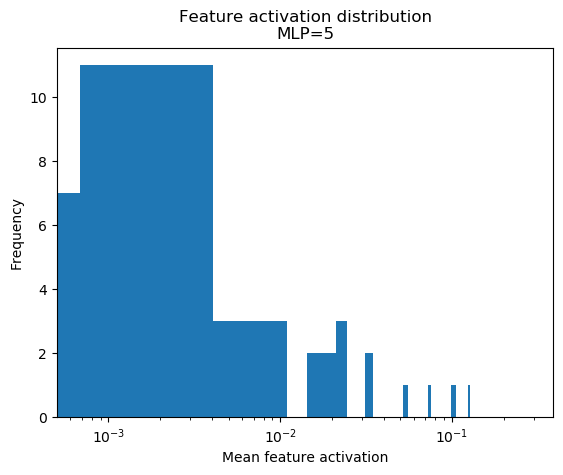

In [19]:
plt.figure()
plt.hist(plural_effect_on_y[plural_effect_on_y.abs() > EPS], bins=100)
plt.xscale('log')
plt.title(f'Feature effect on logit diff distribution\nMLP={layer_patching_on_y}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [20]:
# Need to stack functions to display circuitvis properly
text_neuron_activations(
    topk_prompts_provider(
        feature_layer=layer_patching_on_y, 
        feature_id=topk_features_on_y[0],
        k=5
))

## Patching on feature activation

In [21]:
downstream_feat_layer = 5
downstream_feat_id = 22167 # 5/22167 seems to activate on singular nouns related do people

k_upstream_feats = 3

In [22]:
from acdc import patching_on_feature_activation
effects, total_effect = patching_on_feature_activation(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    downstream_feature_layer=downstream_feat_layer,
    downstream_feature_id=downstream_feat_id, 
    method='all-folded'
)

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect}')

total metric diff after replacing clean prefix with patch prefix: 2.389716148376465


In [23]:
# Top k features per layer with highest impact on downstream feat activation

topk_effects = sorted(enumerate(plural_effect), key=lambda x: x[1].abs(), reverse=True)

topk_features = []
print(f'Top 10 features in layer {layer_patching_on_y} with highest impact on downstream feat activation')
topk_upstream_feats = t.zeros((len(submodules), k_upstream_feats))
for layer in range(len(submodules)):
    print(f'\n\nLayer {layer}:')
    plural_effect = effects[submodules[layer]][plural_token_pos].detach().cpu()

    # Top k features with highest mean activation
    topk_effects = sorted(enumerate(plural_effect), key=lambda x: x[1].abs(), reverse=True)
    topk_features[layer] = topk_effects[:3]
    for id, eff in topk_effects[:3]:
        print(f'feat {id}:\t {eff}')



Layer 0:
feat 20987:	 1.8057266473770142
feat 15149:	 -1.320497751235962
feat 0:	 0.0


Layer 1:
feat 16149:	 0.181435227394104
feat 14400:	 -0.03838137537240982
feat 25045:	 0.028566457331180573


Layer 2:
feat 8734:	 0.04685451462864876
feat 4770:	 0.024982599541544914
feat 31615:	 -0.010588026605546474


Layer 3:
feat 26928:	 -0.09890806674957275
feat 22260:	 0.03759358078241348
feat 21615:	 0.03652147948741913


Layer 4:
feat 25647:	 0.13976886868476868
feat 26810:	 0.08913157135248184
feat 16301:	 0.0890531912446022


Layer 5:
feat 22167:	 2.013801336288452
feat 10880:	 0.06829008460044861
feat 7352:	 -0.056569550186395645


Exact patching should yield 0 unconnected features in same or later layer. (No bwdpass involved)

In [29]:
tokens, activations = topk_prompts_provider(
    feature_layer=3,
    feature_id=26928,
    k=5
)
text_neuron_activations(tokens, activations)